In [2]:
# In this baseline python notebook, we loaded the dataset from Kaggle and attempted training with
# a simple NN with no hidden layers, 2 and 3 and 4 -convolutional-layers with fully connected layer.
# Also did some work to improve the facial keypoint identification such as blurring the image and 
# movement, and reran through NN to see if accuracy improved

# Reference-https://www.tensorflow.org/get_started/mnist/pros

# Loading required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.INFO)
import matplotlib.pyplot as plt
import scipy.signal



# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

np.random.seed(0)


In [4]:
# Some additional work to improve accuracy: blur images, move images
#flips images horizontally
def flip_images(inputdata):
    data=inputdata.copy()
    origcols = list(data.columns)
    newcols = [item for item in origcols]
    
    for col in data.columns.get_level_values(0)[0:30:2]:
            data[col]=data[col].apply(lambda x: 96-x)
    #print data.head()
    
    flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]
    
    for (a,b) in flip_indices:
        newcols[a],newcols[b] = newcols[b],newcols[a]

    colmap = {}
    for i in range(len(newcols)):
        colmap[origcols[i]]=newcols[i]
    
    data = data[newcols]
    data.rename(columns = colmap,inplace=True)
    #print data.head()

    
    data["Image"] = data["Image"].apply(lambda x: np.fliplr(x.reshape((96,96))).flatten())

    return data


def blur_images(inputdata):
    data=inputdata.copy()
    data["Image"] = data["Image"].apply(lambda x: (scipy.signal.convolve2d(x.reshape((96,96)),np.ones((3,3)), mode='same',boundary="fill")/9.0).ravel() )
    return data

def move_images(inputdata,pixels,orientation):
    #pixels= 5 
    #orientation = 'right'
    data = train.copy()
    (dimx,dimy) = (96,96)
    if orientation == 'right':
        padding = np.zeros((dimx,pixels))
        for i in range(padding.shape[0]):
            for j in range(padding.shape[1]):
                random = np.random.normal(0.5,0.1)
                padding[i][j]= min(max(random,0),1)
                
        data["Image"] = data["Image"].apply(lambda x: np.hstack((padding,x.reshape(96,96)))[:,0:96])
    
        for col in data.columns.get_level_values(0)[0:30:2]:
            data[col]=data[col].apply(lambda x: min(96,x+pixels))
    elif orientation == 'left':
        padding = np.zeros((dimx,pixels))
        for i in range(padding.shape[0]):
            for j in range(padding.shape[1]):
                random = np.random.normal(0.5,0.1)
                padding[i][j]= min(max(random,0),1)
        data["Image"] = data["Image"].apply(lambda x: np.hstack((x.reshape(96,96),padding))[:,pixels:96+pixels])
    
        for col in data.columns.get_level_values(0)[0:30:2]:
            data[col]=data[col].apply(lambda x: max(0,x-pixels))
    elif orientation == 'up':
        padding = np.zeros((pixels,dimy))
        for i in range(padding.shape[0]):
            for j in range(padding.shape[1]):
                random = np.random.normal(0.5,0.1)
                padding[i][j]= min(max(random,0),1)
                
        data["Image"] = data["Image"].apply(lambda x: np.vstack((x.reshape(96,96),padding))[pixels:96+pixels,:])
    
        for col in data.columns.get_level_values(0)[1:30:2]:
            data[col]=data[col].apply(lambda x: max(0,x-pixels))
    elif orientation == 'down':
        padding = np.zeros((pixels,dimy))
        for i in range(padding.shape[0]):
            for j in range(padding.shape[1]):
                random = np.random.normal(0.5,0.1)
                padding[i][j]= min(max(random,0),1)
                
        data["Image"] = data["Image"].apply(lambda x: np.vstack((padding,x.reshape(96,96)))[0:96,:])
    
        for col in data.columns.get_level_values(0)[1:30:2]:
            data[col]=data[col].apply(lambda x: min(96,x+pixels))
    
    data["Image"] = data["Image"].apply(lambda x:x.flatten())
    
    return data
    
    

    


In [6]:
# Create iterator to deliver data & labels in sets of batchSize
def imgs_iterator(data,labels,batchSize):
    startIndex= 0
    totalSize = len(data)
    indices = np.arange(totalSize)
    np.random.shuffle(indices)
    
    for i in range(0,totalSize,batchSize):
            batchIndices = indices[i:i+batchSize]
            yield np.stack(data[batchIndices]),labels[batchIndices],len(batchIndices)

# Same as imgs_iterator but for test data (don't return labels)
def imgs_iterator_predict(data,batchSize):
    startIndex= 0
    totalSize = len(data)
    indices = np.arange(totalSize)
    np.random.shuffle(indices)
    
    for i in range(0,totalSize,batchSize):
        batchIndices = indices[i:i+batchSize]
        
        yield np.stack(data[batchIndices]),len(batchIndices)

# Make predictions according to formula "y = Wx + b" for data set 
# Similar in form to training loop
def make_predictions(data,batch_size):
    predictions_mb=[]
    # Iterate by batch size
    iter_test = imgs_iterator_predict(data,batch_size)
    try:
        next_batch =iter_test.__next__()
        while next_batch!=None:
            
            # Load next batch
            mini_batch,batch_size = next_batch
            
            # Reshape
            mini_batch = np.reshape(mini_batch,(batch_size,9216))
            
            # Make prediction with input data and dropout 
            feed_dict = {x: np.stack(mini_batch), keep_prob: 1.0}
            predictions = y.eval(feed_dict)
            predictions_mb.append(predictions)
            
            next_batch =iter_test.__next__()
    except StopIteration:
        next_batch=None
    results = pd.DataFrame(np.vstack(predictions_mb))
    
    return results

# Generate reports for submission
def generate_results(result):
    submission = pd.read_csv('SampleSubmission.csv')
    IdLookup = pd.read_csv('IdLookupTable.csv')
    IdLookupDict = IdLookup.set_index('RowId').T.to_dict('list')

    
    
    result.columns = dev.columns[0:30]
    output = pd.concat([test["ImageId"],result_test],axis=1)
    
    RowId = np.asarray(submission["RowId"],dtype=int)
    for row in RowId:
        r = IdLookupDict[row][0]-1
        c =IdLookupDict[row][1]
        submission.loc[row-1,"Location"]= min(96,(output.loc[r,c]))
    
    
    submission.to_csv("submission.csv",index=False)


In [7]:
# Loading the test and raw training datasets
# Raw is 7049X31.  7049 training examples, 30 columns of facial feature x &y locations, 1 column for list of image pixel values
# Test is 1783X2. 1783 test examples, 1 column for image id, 1 column for list of image pixel values
raw = pd.read_csv('/home/ubuntu/FacialKeypoints/data/training.csv')
test = pd.read_csv('/home/ubuntu/FacialKeypoints/data/test.csv')


# Converting image data into numpy arrays and scaling the images
raw["Image"] = raw["Image"].apply(lambda x: np.asarray(x.split(" "),dtype=np.float32)/255)
test["Image"] = test["Image"].apply(lambda x: np.asarray(x.split(" "),dtype=np.float32)/255)


In [8]:
# Dropping training & test cases with na values since they will prevent the model from training correctly.
# Possibly revisit this to come up with a better approach
raw.dropna(inplace=True)
test.dropna(inplace=True)


# After removing the cases with 'na', re-shuffle (the training set) and re-do indexing
raw = raw.sample(frac=1)
raw.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)


In [10]:
raw = pd.concat([raw,flip_images(raw)],axis=0)
raw = raw.sample(frac=1)
#,move_images(train,15,"right"),move_images(train,15,"left")
                  #,move_images(train,15,"up"),move_images(train,15,"down")

raw.reset_index(inplace=True,drop=True)

In [12]:
# Our training data set has 2140 examples at this point.  
# Allocate 1800 for training and 340 for development.
train_size = int(raw.shape[0]*.8)
train = raw.iloc[0:train_size,:]
dev = raw.iloc[train_size:raw.shape[0],:]

# Re-index
train.reset_index(inplace=True,drop=True)
dev.reset_index(inplace=True,drop=True)

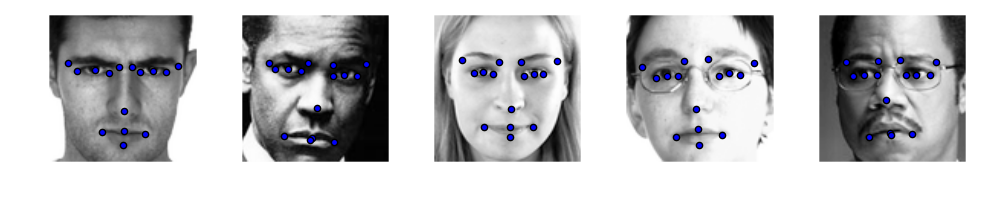

In [13]:
# Visualize 5 example images:
def plot_images(num_images,data, result=None,training=True):
    plt.figure(figsize=(12,4))
    for i in range(num_images):
        
        # Every example has 30 facial features and 1 column with a 9216-length list of pixel values of image
        # take the 9216 list of pixels and reshape into 96X96 image for viewing
        img =  np.reshape(data.ix[i:i,"Image"].values[0],(96,96))
        plt.subplot(1,num_images,i+1)
        plt.axis('off')
        
        # Show the facial image
        plt.imshow(img,cmap='Greys_r')

        # Get x & y values for the facial keypoints and overlay on the face
        x_values = np.asarray(data[data.columns.get_level_values(0)[0:30:2]])
        y_values = np.asarray(data[data.columns.get_level_values(0)[1:30:2]])
        plt.scatter(x_values[i],y_values[i])
        
        # If we are not using training data, then show our predicted facial keypoints with red x's
        if training==False:
            rx_values = np.asarray(result[result.columns.get_level_values(0)[0:30:2]])
            ry_values = np.asarray(result[result.columns.get_level_values(0)[1:30:2]])
            plt.scatter(rx_values[i],ry_values[i],marker="x",color='r')
            

plot_images(5,train)

In [14]:

# Convert the pixel arrays and facial feature locations in train/dev/test into numpy-array representation
train_data = train["Image"].as_matrix()
train_labels = np.asarray(train[train.columns.get_level_values(0)[0:30]]).astype(dtype = np.float32)

dev_data = dev["Image"].as_matrix()
dev_labels = np.asarray(dev[dev.columns.get_level_values(0)[0:30]]).astype(dtype = np.float32)

test_data = test["Image"].as_matrix()

In [ ]:
# Single layer neural network with NO hidden units

# Try running through the entire training data 200 times in batches of 20
batch_size=20
epochs = 200

# Will contain image pixels as we run the training loop
x = tf.placeholder(tf.float32, shape=[None, 9216])
# Will contain facial feature locations as we run training loop
y_ = tf.placeholder(tf.float32, shape=[None, 30])

# Weights/bias for our simple NN
W = tf.Variable(tf.zeros([9216,30]))
b = tf.Variable(tf.zeros([30]))


# Prediction function "y=Wx+b"
y = tf.matmul(x,W) + b

# Define loss function as RMSE, and minimize by GradientDescent
error = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y_,y))))
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(error)

# Initialize all tf.Variable instances
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

for i in range(epochs):
    
    # Move through training data in increments of 20
    iter_ = imgs_iterator(train_data,train_labels,batch_size)
    try:
        next_batch =iter_.__next__()
        while next_batch!=None:
            
            # Load next batch
            train_data_instance,train_label_instance,batch_size = next_batch
            train_instance = np.reshape(train_data_instance,(batch_size,9216))
            train_label_instance = np.reshape(train_label_instance,(batch_size,30))

            # Accuracy (for display)
            train_accuracy = error.eval(feed_dict={x: train_instance, y_: train_label_instance})
            
            # Run training with next batch of 20 training examples
            train_step.run(feed_dict={x: train_instance, y_: train_label_instance})
            next_batch =iter_.__next__()
    except StopIteration:
        next_batch=None
    if i%10==0:
        
        # Display our RMSE for every 10th epoch
        print ("RMSE for Epoch "+str(i)+" ="+str(train_accuracy))



RMSE for Epoch 0 =16.8177


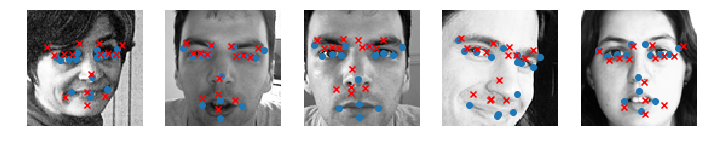

In [9]:
# Generate predictions
feed_dict = {x: np.stack(train_data)}
predictions = y.eval(feed_dict)
# Plot predictions
result =pd.DataFrame(np.stack(np.transpose(predictions),axis=1))
plot_images(5,data =train,result=result,training=False)

In [ ]:
# Try 2-convolutional-layers, 1 fully connected

mini_batch_size=300
epochs = 40

# Set weights as 4D array of random values from truncated normal dist (most-common method)
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

# Set constant bias
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# Compute 2D convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

# Max pool on the input
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')



# Will contain image pixels as we run the training loop
x = tf.placeholder(tf.float32, shape=[None, 9216])
# Will contain facial feature locations as we run training loop
y_ = tf.placeholder(tf.float32, shape=[None, 30])

# Reshape image to format [batch, in-height, in-width, in_channels] to run conv2d on it
# Batch is -1 since don't know batch size yet
x_image = tf.reshape(x, [-1,96,96,1])


# Weights will be 4D tensor of size 5x5x1x32 from truncated normal, 32-length array bias of constant 0.1
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])


# x_image is in shape [batch, in_height, in_width, in_channels] ~ [-1, 96, 96, 1]
# W_conv1 is in shape [filter_height, filter_width, in_channels, out_channels] ~ [5,5,1,32]
# conv2d flattens the filter to a 2-D matrix with shape [filter_height * filter_width * in_channels, output_channels]
#      ~ [5*5*1, 32] ~ [25, 32]
# Apply rectifier relu function
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

# Perform reduction.  h_conv1 is [?,96,96,32] with strides [1,2,2,1]
# Returns a 48*48 image with 32 filters
h_pool1 = max_pool_2x2(h_conv1)

# 2nd convolutional layer - will return 24*24 image with 64 filters
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)


# Flatten resulting image to apply relu activation
h_pool2_flat = tf.reshape(h_pool2, [-1, 24*24*64])

# Fully connected layer
W_fc1 = weight_variable([24 * 24 * 64, 1024])
b_fc1 = bias_variable([1024])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# Apply dropout to prevent overfitting
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# Determine prediction function "y=Wx+b"
W_fc2 = weight_variable([1024, 30])
b_fc2 = bias_variable([30])
y = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

# Define loss function, try minimize with AdamOptimizer (more efficient than gradient descent)
error = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y_,y))))
train_step = tf.train.AdamOptimizer(1e-3).minimize(error)


with tf.Session() as sess:
    # Initialize global vars
    sess.run(tf.global_variables_initializer())
    for i in range(epochs):
        
        # Iterate over training data in increments of (mini_batch_size-1)
        iter_ = imgs_iterator(train_data,train_labels,mini_batch_size-1)
        try:
            next_batch =iter_.__next__()
            while next_batch!=None:
                
                # Load next batch
                train_data_instance,train_label_instance,batch_size = next_batch
                
                # Reshape 
                train_instance = np.reshape(train_data_instance,(batch_size,9216))
                train_label_instance = np.reshape(train_label_instance,(batch_size,30))
                
                # Determine accuracy
                train_accuracy = error.eval(feed_dict={x: train_instance, y_: train_label_instance, keep_prob: 1.0})

                # Run training with next batch of 20 training examples
                sess.run(train_step,feed_dict={x: train_instance, y_: train_label_instance, keep_prob: 0.5})
                next_batch =iter_.__next__()
        except StopIteration:
            next_batch=None
        
        print ("RMSE for Epoch "+str(i)+" ="+str(train_accuracy))
        
    
    # Measure accuracy with trained NN on dev data
    iter_dev = imgs_iterator(dev_data,dev_labels,batch_size)
    
    # Get batch of 20 from dev data
    next_batch =iter_dev.__next__()
    dev_data_instance,dev_label_instance,batch_size = next_batch
    
    # Reshape
    dev_instance = np.reshape(dev_data_instance,(batch_size,9216))
    dev_label_instance = np.reshape(dev_label_instance,(batch_size,30))
    
    # Calculate accuracy
    dev_accuracy = error.eval(feed_dict={x: dev_instance, y_: dev_label_instance, keep_prob: 1.0})
    print ("RMSE for dev set ="+str(dev_accuracy))
    
    

    # Generate predictions for display
    feed_dict = {x: np.stack(train_data), keep_prob: 1.0}
    predictions = y.eval(feed_dict)
    result =pd.DataFrame(np.stack(np.transpose(predictions),axis=1))



RMSE for Epoch 0 =14.1131
RMSE for Epoch 1 =13.5083
RMSE for Epoch 2 =12.8494
RMSE for Epoch 3 =12.4349
RMSE for Epoch 4 =11.3313
RMSE for Epoch 5 =14.5045
RMSE for Epoch 6 =14.0772
RMSE for Epoch 7 =12.4974
RMSE for Epoch 8 =13.0206
RMSE for Epoch 9 =11.1705
RMSE for Epoch 10 =12.9336
RMSE for Epoch 11 =10.4756
RMSE for Epoch 12 =12.037
RMSE for Epoch 13 =11.3438
RMSE for Epoch 14 =11.1785
RMSE for Epoch 15 =10.8691
RMSE for Epoch 16 =10.6719
RMSE for Epoch 17 =11.1994
RMSE for Epoch 18 =12.3484
RMSE for Epoch 19 =10.9555
RMSE for Epoch 20 =5.87268
RMSE for Epoch 21 =12.0702
RMSE for Epoch 22 =9.73929


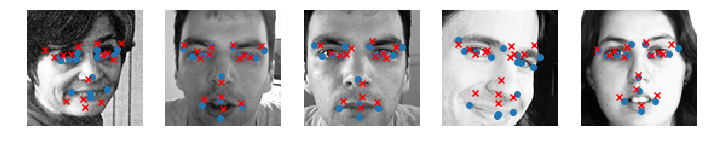

In [11]:
# Plot our predictions
plot_images(5,data =train,result=result,training=False)

In [12]:
# Try 3 convolutional layers, 1 fully connected

mini_batch_size=100
epochs = 50

# Set weights as 4D array of random values from truncated normal dist (most-common method)
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

# Set constant bias
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# Compute 2D convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

# Max pool on the input
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')


# Will contain image pixels as we run the training loop
x = tf.placeholder(tf.float32, shape=[None, 9216])
# Will contain facial feature locations as we run training loop
y_ = tf.placeholder(tf.float32, shape=[None, 30])

# Reshape image to format [batch, in-height, in-width, in_channels] to run conv2d on it
# Batch is -1 since don't know batch size yet
x_image = tf.reshape(x, [-1,96,96,1])

# Same as previous exercize, return a 48*48 image with 32 filters
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# Same as previous exercise, next return a 24*24 image with 64 filters
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# Our third convolutional layer, returns a 12*12 image with 128 filters
W_conv3 = weight_variable([5, 5, 64, 128])
b_conv3 = bias_variable([128])
h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
h_pool3 = max_pool_2x2(h_conv3)


# Flatten resulting image to apply relu activation
h_pool3_flat = tf.reshape(h_pool3, [-1, 12*12*128])

# Fully connected layer
W_fc1 = weight_variable([12 * 12 * 128, 1024])
b_fc1 = bias_variable([1024])
h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)

# Dropout to prevent overfitting
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)


# Apply error function with prediction function "y= xW+b" as previously
W_fc2 = weight_variable([1024, 30])
b_fc2 = bias_variable([30])
y = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

# Define loss function, try minimize with AdamOptimizer
error = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y_,y))))
train_step = tf.train.AdamOptimizer(1e-4).minimize(error)

epoch=[i for i in range(epochs)]

# Collect magnitudes of the training and dev errors over epochs for visualization
train_error = []
dev_error = []

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    # Initialize global vars
    sess.run(tf.global_variables_initializer())
    for i in range(epochs):
        # Iterate over training data in increments of (mini_batch_size-1)
        iter_ = imgs_iterator(train_data,train_labels,mini_batch_size-1)
        try:
            next_batch =iter_.__next__()
            while next_batch!=None:
                
                # Load next batch
                train_data_instance,train_label_instance,batch_size = next_batch
                
                # Reshape
                train_instance = np.reshape(train_data_instance,(batch_size,9216))
                train_label_instance = np.reshape(train_label_instance,(batch_size,30))
                
                # Calculate accuracy
                train_accuracy = error.eval(feed_dict={x: train_instance, y_: train_label_instance, keep_prob: 1.0})

                # Run training with next batch of 20 training examples
                sess.run(train_step,feed_dict={x: train_instance, y_: train_label_instance, keep_prob: 0.5})
                next_batch =iter_.__next__()
        except StopIteration:
            next_batch=None
        
        print ("RMSE for Epoch "+str(i)+str(" =")+str(train_accuracy))
        train_error.append(train_accuracy)
        
        # Test accuracy on the unseen (dev) data
        iter_dev = imgs_iterator(dev_data,dev_labels,batch_size)
        
        # Get batch of 20 from dev
        next_batch =iter_dev.__next__()
        dev_data_instance,dev_label_instance,batch_size = next_batch
        
        # Reshape
        dev_instance = np.reshape(dev_data_instance,(batch_size,9216))
        dev_label_instance = np.reshape(dev_label_instance,(batch_size,30))
        
        # Calculate accuracy & error
        dev_accuracy = error.eval(feed_dict={x: dev_instance, y_: dev_label_instance, keep_prob: 1.0})
        print ("RMSE for dev set ="+str(dev_accuracy))
        dev_error.append(dev_accuracy)
    
    
    # Generate predictions for training and dev for plotting
    result =make_predictions(train_data, mini_batch_size-1)
    result_dev =make_predictions(dev_data, mini_batch_size-1)

RMSE for Epoch 0 =13.519
RMSE for dev set =11.5296
RMSE for Epoch 1 =6.83953
RMSE for dev set =8.3896
RMSE for Epoch 2 =7.6685
RMSE for dev set =7.23421
RMSE for Epoch 3 =5.75306
RMSE for dev set =6.40316
RMSE for Epoch 4 =6.11195
RMSE for dev set =5.77839
RMSE for Epoch 5 =4.53007
RMSE for dev set =6.39642
RMSE for Epoch 6 =5.26715
RMSE for dev set =4.00572
RMSE for Epoch 7 =4.88223
RMSE for dev set =4.01896
RMSE for Epoch 8 =4.78986
RMSE for dev set =5.08306
RMSE for Epoch 9 =4.01857
RMSE for dev set =3.13392
RMSE for Epoch 10 =4.47652
RMSE for dev set =4.76805
RMSE for Epoch 11 =3.83944
RMSE for dev set =3.26205
RMSE for Epoch 12 =3.75192
RMSE for dev set =3.83299
RMSE for Epoch 13 =4.1086
RMSE for dev set =3.34376
RMSE for Epoch 14 =3.69594
RMSE for dev set =3.43425
RMSE for Epoch 15 =3.8738
RMSE for dev set =4.60233
RMSE for Epoch 16 =3.61146
RMSE for dev set =3.05449
RMSE for Epoch 17 =3.41113
RMSE for dev set =3.16155
RMSE for Epoch 18 =3.87068
RMSE for dev set =3.44167
RMSE for

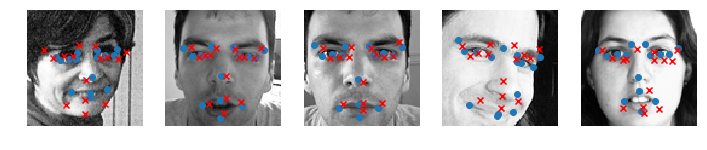

In [13]:
# Plot predictions from training data (better fit than before)
plot_images(5,data =train,result=result,training=False)

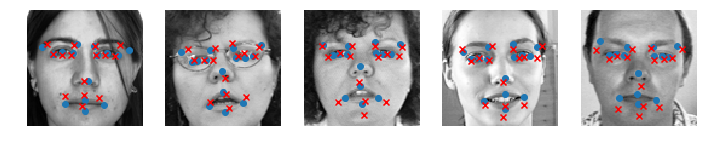

In [14]:
# Plot predictions from dev data
plot_images(5,data =dev,result=result_dev,training=False)

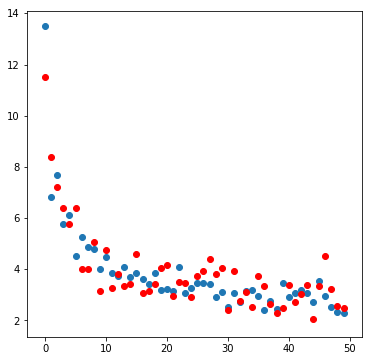

In [15]:

# Plot the magnitudes of error magnitudes in dev and training set by epoch
plt.figure(figsize=(6,6))
plt.scatter(epoch,train_error)
plt.scatter(epoch,dev_error,color="red")



In [16]:
# Try 4 convolutional layers, 1 fully connected

mini_batch_size=100
epochs = 400

# Set weights as 4D array of random values from truncated normal dist (most-common method)
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

# Set constant bias
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# Compute 2D convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

# Max pool on the input
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')

# Will contain image pixels as we run the training loop
x = tf.placeholder(tf.float32, shape=[None, 9216])
# Will contain facial feature locations as we run training loop
y_ = tf.placeholder(tf.float32, shape=[None, 30])

# Reshape image to format [batch, in-height, in-width, in_channels] to run conv2d on it
# Batch is -1 since don't know batch size yet
x_image = tf.reshape(x, [-1,96,96,1])#-1 because we don't know the batch size yet.

# Same as previous exercize, return a 48*48 image with 32 filters
W_conv1 = weight_variable([3, 3, 1, 32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# Same as previous exercise, next return a 24*24 image with 64 filters
W_conv2 = weight_variable([3, 3, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# Same as previous exercise, next return a 12*12 image with 128 filters
W_conv3 = weight_variable([3, 3, 64, 128])
b_conv3 = bias_variable([128])
h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
h_pool3 = max_pool_2x2(h_conv3)

# Fourth convolutional layer, returns a 6*6 image with 256 filters
W_conv4 = weight_variable([3, 3, 128, 256])
b_conv4 = bias_variable([256])
h_conv4 = tf.nn.relu(conv2d(h_pool3, W_conv4) + b_conv4)
h_pool4 = max_pool_2x2(h_conv4) #returns a 6*6 image with 256 filters

# Flatten resulting image for matrix multiplication
h_pool4_flat = tf.reshape(h_pool4, [-1, 6*6*256])
# Fully connected layer
W_fc1 = weight_variable([6 * 6 * 256, 1024])
b_fc1 = bias_variable([1024])
h_fc1 = tf.nn.relu(tf.matmul(h_pool4_flat, W_fc1) + b_fc1)

# Dropout to prevent overfitting
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# Prediction y=xW+b
W_fc2 = weight_variable([1024, 30])
b_fc2 = bias_variable([30])
y = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

# Define RMSE loss function, minimize with AdamOptimizer
error = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y_,y))))
train_step = tf.train.AdamOptimizer(1e-3).minimize(error)


epoch=[i for i in range(epochs)]

# Collect train and dev error magnitudes for visualization
train_error = []
dev_error = []

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(epochs):
        
        # Iterate over training data in steps of (mini_batch_size-1)
        iter_ = imgs_iterator(train_data,train_labels,mini_batch_size-1)
        try:
            next_batch =iter_.__next__()
            while next_batch!=None:
                
                # Load next batch
                train_data_instance,train_label_instance,batch_size = next_batch
                
                # Reshape
                train_instance = np.reshape(train_data_instance,(batch_size,9216))
                train_label_instance = np.reshape(train_label_instance,(batch_size,30))
                
                # Calculate accuracy
                train_accuracy = error.eval(feed_dict={x: train_instance, y_: train_label_instance, keep_prob: 1.0})

                # Run training with next batch of 20 training examples
                sess.run(train_step,feed_dict={x: train_instance, y_: train_label_instance, keep_prob: 0.5})
                next_batch =iter_.__next__()
        except StopIteration:
            next_batch=None
        
        print ("RMSE for Epoch "+str(i)+str(" =")+str(train_accuracy))
        train_error.append(train_accuracy)
        
        # Test accuracy on the unseen (dev) data
        iter_dev = imgs_iterator(dev_data,dev_labels,batch_size)
        
        # Get batch of 20 from dev
        next_batch =iter_dev.__next__()
        dev_data_instance,dev_label_instance,batch_size = next_batch
        
        # Reshape
        dev_instance = np.reshape(dev_data_instance,(batch_size,9216))
        dev_label_instance = np.reshape(dev_label_instance,(batch_size,30))
        
        # Calculate accuracy & error
        dev_accuracy = error.eval(feed_dict={x: dev_instance, y_: dev_label_instance, keep_prob: 1.0})
        print ("RMSE for dev set ="+str(dev_accuracy))
        dev_error.append(dev_accuracy)
    
    

    # Generate predictions for train/dev/test
    result =make_predictions(train_data, mini_batch_size-1)
    result_dev =make_predictions(dev_data, mini_batch_size-1)
    result_test =make_predictions(test_data, mini_batch_size-1)

RMSE for Epoch 0 =6.37455
RMSE for dev set =3.76145
RMSE for Epoch 1 =4.53869
RMSE for dev set =4.47585
RMSE for Epoch 2 =3.36184
RMSE for dev set =4.39578
RMSE for Epoch 3 =3.54521
RMSE for dev set =3.74687
RMSE for Epoch 4 =4.12031
RMSE for dev set =3.98102
RMSE for Epoch 5 =2.61943
RMSE for dev set =3.60994
RMSE for Epoch 6 =3.21233
RMSE for dev set =3.55331
RMSE for Epoch 7 =3.25587
RMSE for dev set =2.57262
RMSE for Epoch 8 =3.48077
RMSE for dev set =3.88134
RMSE for Epoch 9 =3.78328
RMSE for dev set =2.87908
RMSE for Epoch 10 =3.67231
RMSE for dev set =2.45481
RMSE for Epoch 11 =3.47098
RMSE for dev set =3.13466
RMSE for Epoch 12 =2.54113
RMSE for dev set =3.39081
RMSE for Epoch 13 =2.81402
RMSE for dev set =2.81703
RMSE for Epoch 14 =3.1274
RMSE for dev set =3.02767
RMSE for Epoch 15 =3.19646
RMSE for dev set =3.68966
RMSE for Epoch 16 =2.40194
RMSE for dev set =2.91503
RMSE for Epoch 17 =2.82997
RMSE for dev set =2.74767
RMSE for Epoch 18 =2.88601
RMSE for dev set =4.59474
RMSE

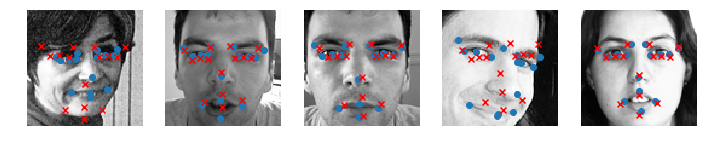

In [17]:
# Plot predictions from train_data
plot_images(5,data =train,result=result,training=False)

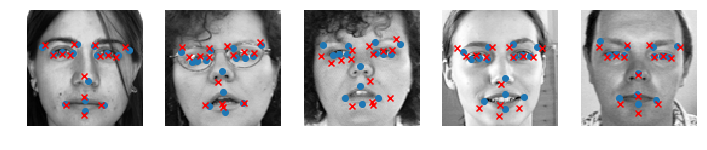

In [18]:
# Plot predictions from dev data
plot_images(5,data =dev,result=result_dev,training=False)

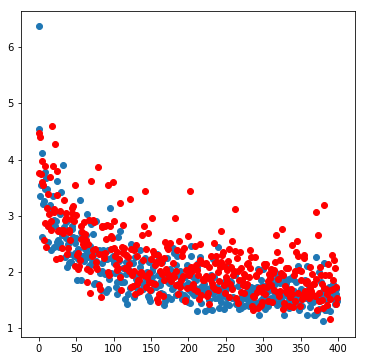

In [19]:

# Plot train/dev errors by epoch
plt.figure(figsize=(6,6))
plt.scatter(epoch,train_error)
plt.scatter(epoch,dev_error,color="red")


   left_eye_center_x  left_eye_center_y  right_eye_center_x  \
0          64.491468          36.682220           34.606327   
1          68.171024          37.394526           28.757742   
2          65.170286          35.169600           22.923918   
3          64.875888          43.074754           27.556650   
4          65.428645          35.514839           29.051183   

   right_eye_center_y  left_eye_inner_corner_x  left_eye_inner_corner_y  \
0           40.254668                57.649633                38.177157   
1           36.368383                60.781321                37.599847   
2           35.826269                58.384653                36.264049   
3           34.126633                61.204384                42.310884   
4           35.828645                57.275183                36.455570   

   left_eye_outer_corner_x  left_eye_outer_corner_y  right_eye_inner_corner_x  \
0                72.157005                36.220904                 40.302491   
1       

'\n# Plot rows moving image to all 4 orientations\nplot_images(5,move_images(train,15,"right"))\nplot_images(5,move_images(train,15,"left"))\nplot_images(5,move_images(train,15,"up"))\nplot_images(5,move_images(train,15,"down"))'

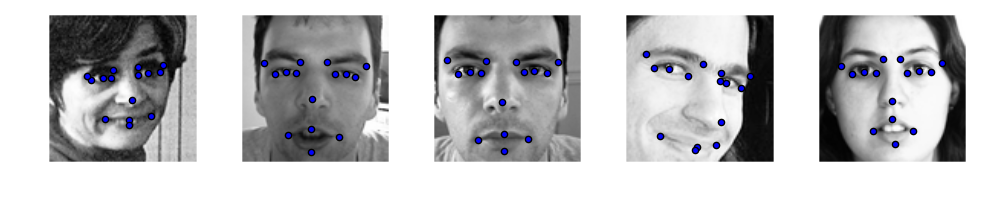

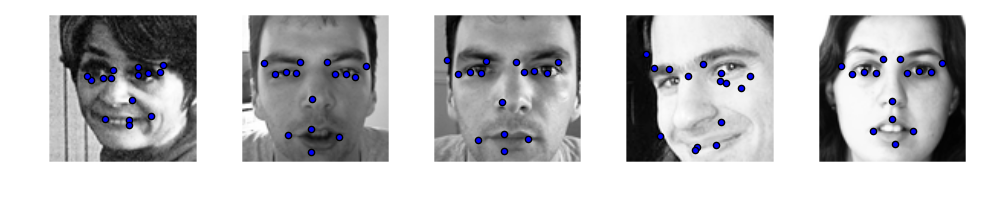

In [12]:
# Plot a row of the original image
plot_images(5,train)


# Plot a row of flipped images
plot_images(5,flip_images(train))
'''
# Plot rows moving image to all 4 orientations
plot_images(5,move_images(train,15,"right"))
plot_images(5,move_images(train,15,"left"))
plot_images(5,move_images(train,15,"up"))
plot_images(5,move_images(train,15,"down"))'''

In [14]:
# We start from the beginning, loading the original training/dev/test data, for the purpose of appending
#   our blurred/moved images to the original dataset to measure accuracy

# Loading the test and raw training datasets
raw = pd.read_csv('/Users/vyas/Dropbox/Berkeley MIDS/Applied Machine Learning/coursework/Projects/Facial Keypoints Detection/data/training.csv')
test = pd.read_csv('/Users/vyas/Dropbox/Berkeley MIDS/Applied Machine Learning/coursework/Projects/Facial Keypoints Detection/data/test.csv')


# Converting image data into numpy arrays and scaling the images
raw["Image"] = raw["Image"].apply(lambda x: np.asarray(x.split(" "),dtype=np.float32)/255)
test["Image"] = test["Image"].apply(lambda x: np.asarray(x.split(" "),dtype=np.float32)/255)

# Remove rows with 'na', reshuffle, and re-index
raw.dropna(inplace=True)
test.dropna(inplace=True)
raw = raw.sample(frac=1)
raw.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

# Set first 1800 of the raw data to be training, and the remaining to be dev data
train_size = 1800
train = raw.iloc[0:train_size,:]
dev = raw.iloc[train_size:raw.shape[0],:]
train.reset_index(inplace=True,drop=True)
dev.reset_index(inplace=True,drop=True)

In [15]:
# Now blur all images in the training set, and append results to our training set
train = pd.concat([train,flip_images(train)],axis=0)

# Re-index
train.reset_index(inplace=True,drop=True)

   left_eye_center_x  left_eye_center_y  right_eye_center_x  \
0          64.238873          37.341296           30.701746   
1          68.876849          37.386957           29.782579   
2          65.722219          38.521084           29.785394   
3          65.410406          42.557114           29.996182   
4          65.151549          36.672000           27.431324   

   right_eye_center_y  left_eye_inner_corner_x  left_eye_inner_corner_y  \
0           34.622062                59.404394                37.643425   
1           36.730758                60.144365                38.472207   
2           37.356387                59.566142                38.853987   
3           37.743756                58.969342                43.463978   
4           37.596507                56.276282                37.966310   

   left_eye_outer_corner_x  left_eye_outer_corner_y  right_eye_inner_corner_x  \
0                70.281465                38.549814                 36.744338   
1       

In [16]:
# Convert train/dev/test to numpy array representations
train_data = train["Image"].as_matrix()
train_labels = np.asarray(train[train.columns.get_level_values(0)[0:30]]).astype(dtype = np.float32)

dev_data = dev["Image"].as_matrix()
dev_labels = np.asarray(dev[dev.columns.get_level_values(0)[0:30]]).astype(dtype = np.float32)

test_data = test["Image"].as_matrix()

In [17]:
print (train_data.shape)
print (train.shape)
print (dev_data.shape)
print (dev.shape)

(3600,)
(3600, 31)
(340,)
(340, 31)


In [18]:
# Try 2 convolutional layers, 2 fully connected layers

mini_batch_size=300
epochs = 25


# Set weights as 4D array of random values from truncated normal dist (most-common method)
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

# Set constant bias
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# Compute 2D convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

# Max pool on the input
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')

# Will contain image pixels as we run the training loop
x = tf.placeholder(tf.float32, shape=[None, 9216])
# Will contain facial feature locations as we run training loop
y_ = tf.placeholder(tf.float32, shape=[None, 30])


# Reshape image to format [batch, in-height, in-width, in_channels] to run conv2d on it
# Batch is -1 since don't know batch size yet
x_image = tf.reshape(x, [-1,96,96,1])

# Same as previous exercize, return a 48*48 image with 32 filters
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)


# Same as previous exercise, next return a 24*24 image with 64 filters
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2) #returns a 24*24 image with 64 filters


# Fully connected layer
W_fc1 = weight_variable([24 * 24 * 64, 1024])
b_fc1 = bias_variable([1024])
h_pool2_flat = tf.reshape(h_pool2, [-1, 24*24*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# Dropout to prevent overfit
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# Fully connected layer
W_fc2 = weight_variable([1024, 1024])
b_fc2 = bias_variable([1024])
h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

# Prediction function
W_fc3 = weight_variable([1024, 30])
b_fc3 = bias_variable([30])
y = tf.matmul(h_fc2_drop, W_fc3) + b_fc3

# Define RMSE error, minimize with AdamOptimizer
error = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y_,y))))
train_step = tf.train.AdamOptimizer(1e-2).minimize(error)

epoch=[i for i in range(epochs)]

# Track train/dev errors for plotting
train_error = []
dev_error = []

# GPU settings
config = tf.ConfigProto()
config.gpu_options.allow_growth=True


with tf.Session(config=config) as sess:
    
    # Initialize global vars
    sess.run(tf.global_variables_initializer())
    for i in range(epochs):
        
        # Iterate by batch size
        iter_ = imgs_iterator(train_data,train_labels,mini_batch_size-1)
        try:
            next_batch =iter_.__next__()
            while next_batch!=None:
                
                # Load next batch
                train_data_instance,train_label_instance,batch_size = next_batch
                
                # Reshape
                train_instance = np.reshape(train_data_instance,(batch_size,9216))
                train_label_instance = np.reshape(train_label_instance,(batch_size,30))
                
                # Calculate acccuracy
                train_accuracy = error.eval(feed_dict={x: train_instance, y_: train_label_instance, keep_prob: 1.0})

                # Run training with next batch of training data
                sess.run(train_step,feed_dict={x: train_instance, y_: train_label_instance, keep_prob: 0.5})
                next_batch =iter_.__next__()
        except StopIteration:
            next_batch=None
        
        print ("RMSE for Epoch "+str(i)+str(" =")+str(train_accuracy))
        train_error.append(train_accuracy)
        
    
        # Determine accuracy on our dev data
        iter_dev = imgs_iterator(dev_data,dev_labels,batch_size)
        
        # Get batch of 20
        next_batch =iter_dev.__next__()
        dev_data_instance,dev_label_instance,batch_size = next_batch
        
        # Reshape
        dev_instance = np.reshape(dev_data_instance,(batch_size,9216))
        dev_label_instance = np.reshape(dev_label_instance,(batch_size,30))
        
        # Calculate accuracy & error
        dev_accuracy = error.eval(feed_dict={x: dev_instance, y_: dev_label_instance, keep_prob: 1.0})
        print ("RMSE for dev set ="+str(dev_accuracy))
        dev_error.append(dev_accuracy)
    
    

    #Predictions on train/dev/test for plotting
    result =make_predictions(train_data, mini_batch_size-1)
    result_dev =make_predictions(dev_data, mini_batch_size-1)
    result_test =make_predictions(test_data, mini_batch_size-1)
    
    sess.close()

KeyboardInterrupt: 

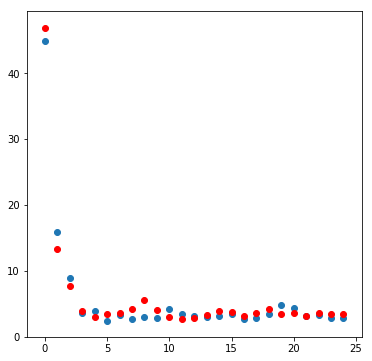

In [27]:
# Plot training and dev errors by epoch
plt.figure(figsize=(6,6))
plt.scatter(epoch,train_error)
plt.scatter(epoch,dev_error,color="red")


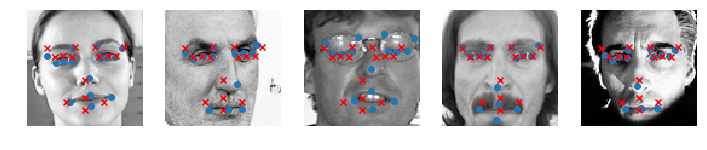

In [28]:
# Plot predicted facial keypoints from dev_data
plot_images(5,dev,result_dev,False) 

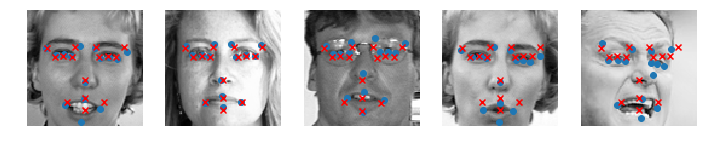

In [29]:
# Plot predicted facial keypoints from test_data
plot_images(5,train,result,False)

In [32]:
# Submission
generate_results(result_test)